### Reading Data and Tokenization

In [1]:
import pandas as pd

data = pd.read_csv("data/fra.txt",sep='\t',header= None)
ang = list(data[0])
fra = list(data[1])

from spacy.lang.en import English
from spacy.lang.fr import French

nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)
nlp_f = French()
tokenizer_f = nlp_f.Defaults.create_tokenizer(nlp_f)

ang = [['<S>'] + [token.string.strip() for token in tokenizer(text.lower())] + ['</S>'] for text in ang][:10000]

fra = [['<S>'] + [token.string.strip() for token in tokenizer_f(text.lower())] + ['</S>'] for text in fra][:10000]

### Padding, word2id and shifting

In [2]:
from gensim.models import Word2Vec
import numpy as np

EMBEDDING_SIZE = 120
w2v = Word2Vec(ang, size=EMBEDDING_SIZE, window=10, min_count=1, negative=10, workers=10)
word_map = {}
word_map["<PAD>"] = 0
word_vectors = [np.zeros((EMBEDDING_SIZE,))]
for i, w in enumerate([w for w in w2v.wv.vocab]):
    word_map[w] = i+1
    word_vectors.append(w2v.wv[w])
word_vectors = np.vstack(word_vectors)

w2v = Word2Vec(fra, size=EMBEDDING_SIZE, window=10, min_count=1, negative=10, workers=10)
word_map_fr = {}
word_map_fr["<PAD>"] = 0
word_vectors_fr = [np.zeros((EMBEDDING_SIZE,))]
for i, w in enumerate([w for w in w2v.wv.vocab]):
    word_map_fr[w] = i+1
    word_vectors_fr.append(w2v.wv[w])
word_vectors_fr = np.vstack(word_vectors_fr)
i2w = dict(zip([*word_map_fr.values()],[*word_map_fr]))


In [3]:
def pad(a,shift = False):
    shape = len(a)
    max_s = max([len(x) for x in a])
    if shift:
        token = np.zeros((shape,max_s+1),dtype = np.int)
        mask  =  np.zeros((shape,max_s+1),dtype = np.int)
        for i,o in enumerate(a):
            token[i,:len(o)] = o
            mask[i,:len(o)] = 1
        return token[:,1:],mask[:,1:],max_s       
    else:            
        token = np.zeros((shape,max_s),dtype = np.int)
        mask  =  np.zeros((shape,max_s),dtype = np.int)
        for i,o in enumerate(a):
            token[i,:len(o)] = o
            mask[i,:len(o)] = 1
        return token,mask,max_s 
    
ang_tok,ang_mask,ang_pl = pad([[word_map[w] for w in text] for text in ang])
fra_tok,fra_mask,fr_pl = pad([[word_map_fr[w] for w in text] for text in fra])
fra_toks_s,fra_mask_s,_ = pad([[word_map_fr[w] for w in text] for text in fra],shift = True)

### Seq2Seq model

In [4]:
from tensorflow.keras import layers,Model
from tensorflow.keras.initializers import Constant
import tensorflow as tf

class S2S(tf.keras.Model):
    def __init__(self,Win,Wout,i2w):
      
        super(S2S, self).__init__() 
        
        self.nv_in = Win.shape[0]
        self.r = Win.shape[1]
        self.nv_out = Wout.shape[0]
        
        self.i2w = i2w
        
        self.Win = layers.Embedding(self.nv_in,self.r)
        self.Win.build((None, ))
        self.Win.set_weights([Win])
        self.Win.trainable = True

        self.Wout = layers.Embedding(self.nv_out,self.r)
        self.Wout.build((None, ))
        self.Wout.set_weights([Wout])
        self.Wout.trainable = True
        
        self.encoder = layers.GRU(self.r, return_sequences=True, return_state=True,dropout=0.2)
        
        self.decoder = layers.GRU(self.r, return_sequences=True, return_state=True,dropout=0.2)
        
        self.mapper = layers.Dense(self.nv_out,activation = "softmax")

        self.attention = layers.Attention()

        self.H = layers.Dense(self.r*2,activation = "tanh")

        self.W = layers.Dense(self.r,activation = "linear")

    @tf.function
    def encode(self,x,x_mask):
        
        x = self.Win(x)
        x_mask = tf.cast(x_mask,dtype=bool)
    
        hidden_seq,hidden_last = self.encoder(x,mask=x_mask)

        return hidden_seq,hidden_last
    
    @tf.function
    def decode(self,encoder_seq,encoder_mask,decoder_last,context_last,x_out,attention = False):

        x_out = self.Wout(x_out)

        input_decoder = tf.concat([x_out,context_last],2)

        encoder_mask = tf.cast(encoder_mask,dtype=bool)

        _,decoder_last = self.decoder(input_decoder, initial_state=decoder_last)

        decoder_last = tf.expand_dims(decoder_last,1)
        
        query = self.W(decoder_last)

        key = encoder_seq 
        value = encoder_seq 
            
        context_vector = self.attention([query,key,value],mask = [None,encoder_mask])

        probs = self.mapper(self.H(tf.concat([decoder_last,context_vector],2)))

        decoder_last = tf.squeeze(decoder_last)
        
        if attention == True:
            decoder_last = tf.expand_dims(decoder_last,axis = 0)
            scores = tf.matmul(query, key, transpose_b=True)
            weights = tf.nn.softmax(scores)
            return weights,decoder_last,context_vector
        else:
            return probs,decoder_last,context_vector

 
    def att_wei(self,x,x_mask,x_out,x_out_mask):
        
        x = tf.expand_dims(x,axis=0)
        x_mask = tf.expand_dims(x_mask,axis=0)
        x_out = tf.expand_dims(x_out,axis=0)
        x_out_mask = tf.expand_dims(x_out_mask,axis=0)
        
        mask = tf.cast(tf.matmul(tf.transpose(x_out_mask),x_mask),dtype=tf.bool)

        encoder_seq,hidden_last = model.encode(x,x_mask)
        context_last = tf.zeros([x.shape[0],model.r])
        context_last = tf.expand_dims(context_last,1)

        input_0 = tf.gather(x_out, [0], axis=1)
        
        
        weights,hidden_last,context_last = model.decode(encoder_seq,x_mask,hidden_last,context_last,input_0,attention = True)
        pro = []
        
        pro.append(weights)

        for t in range(1,x_out.shape[1]):
            input_0 = tf.gather(x_out, [t], axis=1)
            weights,hidden_last,context_last = model.decode(encoder_seq,x_mask,hidden_last,context_last,input_0,attention = True)
            pro.append(weights)

        pro = tf.concat(pro,1)
        
        out = tf.boolean_mask(tf.squeeze(pro),mask)
        
        out = tf.reshape(out,(tf.reduce_sum(x_out_mask),tf.reduce_sum(x_mask)))
                
        return out.numpy() 


    
    def generate(self,start_emb,x,x_mask):
        aout = []
        
        x = tf.expand_dims(x,axis=0)
        x_mask = tf.expand_dims(x_mask,axis=0)

        encoder_seq,hidden_last = model.encode(x,x_mask)
        context_last = tf.zeros([x.shape[0],model.r])
        context_last = tf.expand_dims(context_last,1)
       
        input_0 = tf.expand_dims(tf.expand_dims(start_emb,axis=0),axis=0)

        probs,hidden_last,context_last = model.decode(encoder_seq,x_mask,hidden_last,context_last,input_0)

        val,argval = tf.nn.top_k(tf.squeeze(probs), k=2, sorted=True, name=None)
        x_out = argval.numpy()[0]
        aout.append(self.i2w[x_out])
    
        for t in range(10):
            hidden_last = tf.expand_dims(hidden_last,axis=0)
            input_0 = tf.expand_dims(tf.expand_dims(x_out,axis=0),axis=0)
            probs,hidden_last,context_last = model.decode(encoder_seq,x_mask,hidden_last,context_last,input_0)
            
            val,argval = tf.nn.top_k(tf.squeeze(probs), k=2, sorted=True, name=None)
            x_out = argval.numpy()[0]
            aout.append(self.i2w[x_out])
                
        return aout

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

def plot_weight(vegetables,farmers,harvest):
    
    vegetables = vegetables[1:]
    harvest = harvest[0:-1,:]
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(harvest)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(farmers)
    ax.set_yticklabels(vegetables)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, harvest[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Attention")
    fig.tight_layout()
    plt.show()

### Function for optim

In [6]:
@tf.function
def compute_loss(model,loss_f,x,x_mask,x_out,y_onehot,y_mask):
    pro = []
    
    encoder_seq,hidden_last = model.encode(x,x_mask)
    context_last = tf.zeros([x.shape[0],model.r])
    context_last = tf.expand_dims(context_last,1)
    
    input_0 = tf.gather(x_out, [0], axis=1)
    probs,hidden_last,context_last = model.decode(encoder_seq,x_mask,hidden_last,context_last,input_0)

    pro.append(probs)

    for t in range(1,y_onehot.shape[1]):
        input_0 = tf.gather(x_out, [t], axis=1)
        probs,hidden_last,context_last = model.decode(encoder_seq,x_mask,hidden_last,context_last,input_0)
        pro.append(probs)
        
    pro = tf.concat(pro,1)

    y_true= tf.boolean_mask(y_onehot,y_mask)
    y_pred = tf.boolean_mask(pro,y_mask)
    
    
    return loss_f(y_true,y_pred),y_true,y_pred


@tf.function
def compute_apply_gradients(model,loss_f,x,x_mask,x_out,y_onehot,y_mask,optimizer):
    with tf.GradientTape() as tape:
        
        loss,label,prediction = compute_loss(model,loss_f,x,x_mask,x_out,y_onehot,y_mask)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss,label,prediction




### Split

In [7]:
batch_size = 128

X = np.hstack([ang_tok,ang_mask])
print(X.shape)
Y = np.hstack([fra_tok,fra_toks_s,fra_mask_s])
print(Y.shape)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, random_state=101)


train_data = tf.data.Dataset.from_tensor_slices((X_train,Y_train)).batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).batch(batch_size)



(10000, 18)
(10000, 45)


### Model declaration and Losses

In [8]:
from tqdm.notebook import tqdm
import os

model = S2S(word_vectors,word_vectors_fr,i2w)

epochs = 70

optimizer = tf.keras.optimizers.Adam()

checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

loss_f = tf.keras.losses.CategoricalCrossentropy()

tr_loss = []
te_loss = []
tr_acc = []
te_acc = []
 


### Optim

1



Loss: 5.355288505554199, Accuracy: 17.88262176513672, Test Loss: 4.604523658752441, Test Accuracy: 21.380617141723633
2



Loss: 4.850320816040039, Accuracy: 22.660947799682617, Test Loss: 4.40574836730957, Test Accuracy: 26.996902465820312
3



Loss: 4.554872035980225, Accuracy: 26.92559051513672, Test Loss: 4.248377323150635, Test Accuracy: 30.62775993347168
4



Loss: 4.351256370544434, Accuracy: 29.84136962890625, Test Loss: 4.135008335113525, Test Accuracy: 32.99190902709961
5



Loss: 4.197807312011719, Accuracy: 31.74472427368164, Test Loss: 4.039917945861816, Test Accuracy: 34.4930305480957
6



Loss: 4.065399169921875, Accuracy: 33.12103271484375, Test Loss: 3.9515655040740967, Test Accuracy: 35.703216552734375
7



Loss: 3.9390881061553955, Accuracy: 34.64201736450195, Test Loss: 3.856215238571167, Test Accuracy: 37.29188919067383
8



Loss: 3.817171812057495, Accuracy: 36.410221099853516, Test Loss: 3.766502618789673, Test Accuracy: 38.92881774902344
9



Loss: 3.7015304565429688, Accuracy: 38.043888092041016, Test Loss: 3.680968761444092, Test Accuracy: 40.39995193481445
10



Loss: 3.5931477546691895, Accuracy: 39.52971267700195, Test Loss: 3.602032423019409, Test Accuracy: 41.72663116455078
<S> stay thin . </S>
soyez ont lacet de aller . </S> </S> </S> </S> </S>
<S> who wants it ? </S>
est - vous - vous ? </S> ? </S> ? </S>


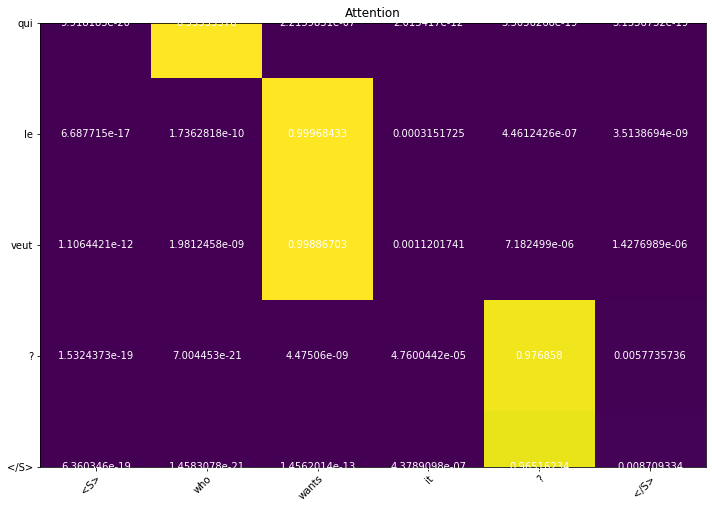

11



Loss: 3.4918060302734375, Accuracy: 40.90428924560547, Test Loss: 3.5298776626586914, Test Accuracy: 42.94042205810547
12



Loss: 3.3955655097961426, Accuracy: 42.208187103271484, Test Loss: 3.4659674167633057, Test Accuracy: 44.040138244628906
13



Loss: 3.304351568222046, Accuracy: 43.4240608215332, Test Loss: 3.40444278717041, Test Accuracy: 45.05210876464844
14



Loss: 3.2180657386779785, Accuracy: 44.56430435180664, Test Loss: 3.3472554683685303, Test Accuracy: 45.977298736572266
15



Loss: 3.1358258724212646, Accuracy: 45.64576721191406, Test Loss: 3.29341983795166, Test Accuracy: 46.821598052978516
16



Loss: 3.0577054023742676, Accuracy: 46.65212631225586, Test Loss: 3.2442831993103027, Test Accuracy: 47.56789016723633
17



Loss: 2.983309268951416, Accuracy: 47.60145568847656, Test Loss: 3.198397397994995, Test Accuracy: 48.2694206237793
18



Loss: 2.912687063217163, Accuracy: 48.507564544677734, Test Loss: 3.154548406600952, Test Accuracy: 48.94847106933594
19



Loss: 2.8452913761138916, Accuracy: 49.37263488769531, Test Loss: 3.11354660987854, Test Accuracy: 49.59183120727539
20



Loss: 2.7801601886749268, Accuracy: 50.217689514160156, Test Loss: 3.0751492977142334, Test Accuracy: 50.18505859375
<S> stay thin . </S>
reste doucement ! </S> </S> sourcils ! </S> </S> </S> </S>
<S> who wants it ? </S>
qui est en t de l' aller ? </S> ? </S>


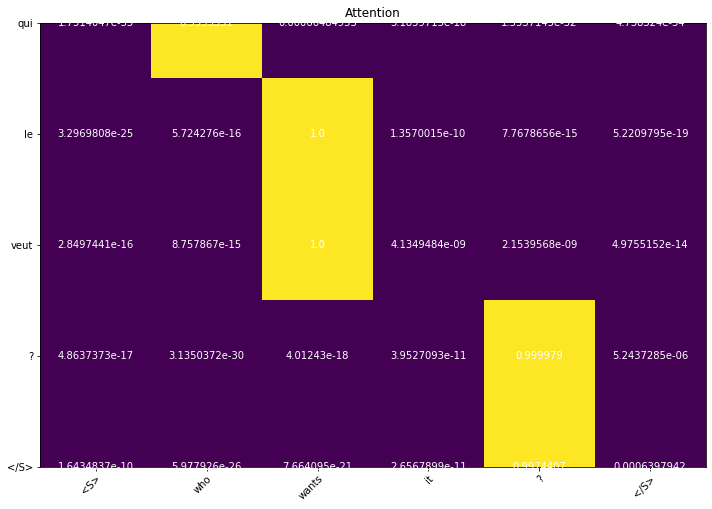

21



Loss: 2.717229127883911, Accuracy: 51.04414749145508, Test Loss: 3.0392110347747803, Test Accuracy: 50.74924850463867
22



Loss: 2.6568684577941895, Accuracy: 51.8423957824707, Test Loss: 3.004610538482666, Test Accuracy: 51.30009460449219
23



Loss: 2.599088668823242, Accuracy: 52.6114387512207, Test Loss: 2.9723052978515625, Test Accuracy: 51.811283111572266
24



Loss: 2.543442726135254, Accuracy: 53.358604431152344, Test Loss: 2.9424970149993896, Test Accuracy: 52.279151916503906
25



Loss: 2.4898455142974854, Accuracy: 54.089874267578125, Test Loss: 2.9155285358428955, Test Accuracy: 52.711307525634766
26



Loss: 2.438547134399414, Accuracy: 54.7984733581543, Test Loss: 2.888129711151123, Test Accuracy: 53.162200927734375
27



Loss: 2.3883934020996094, Accuracy: 55.50550079345703, Test Loss: 2.861950159072876, Test Accuracy: 53.59659194946289
28



Loss: 2.3393776416778564, Accuracy: 56.212223052978516, Test Loss: 2.837190628051758, Test Accuracy: 54.00394821166992
29



Loss: 2.291682243347168, Accuracy: 56.90966796875, Test Loss: 2.8134536743164062, Test Accuracy: 54.39448928833008
30



Loss: 2.2454047203063965, Accuracy: 57.5998420715332, Test Loss: 2.7909798622131348, Test Accuracy: 54.76961135864258
<S> stay thin . </S>
reste doucement ! </S> ! </S> </S> chose . </S> .
<S> who wants it ? </S>
qui veut cela ? </S> ? </S> ? </S> ? </S>


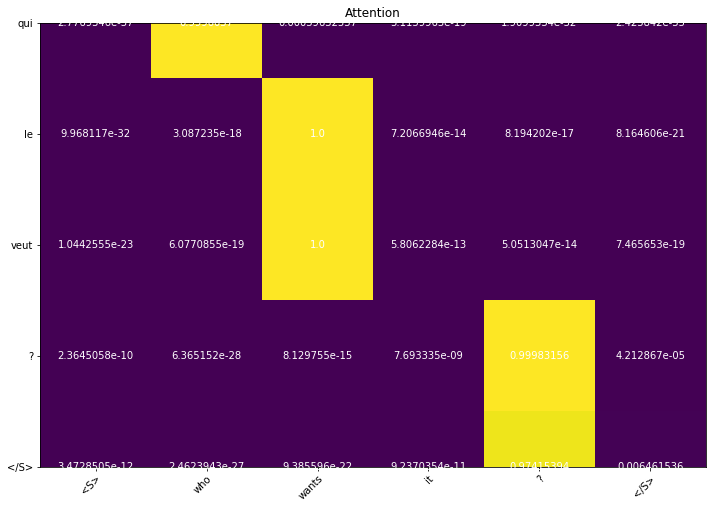

31



Loss: 2.200639247894287, Accuracy: 58.275108337402344, Test Loss: 2.7694826126098633, Test Accuracy: 55.13691329956055
32



Loss: 2.157426357269287, Accuracy: 58.93214797973633, Test Loss: 2.7496426105499268, Test Accuracy: 55.4766845703125
33



Loss: 2.1156651973724365, Accuracy: 59.57647705078125, Test Loss: 2.7313666343688965, Test Accuracy: 55.79090881347656
34



Loss: 2.0753061771392822, Accuracy: 60.206668853759766, Test Loss: 2.7133023738861084, Test Accuracy: 56.10918426513672
35



Loss: 2.036381244659424, Accuracy: 60.81870651245117, Test Loss: 2.6963131427764893, Test Accuracy: 56.40803527832031
36



Loss: 1.9989285469055176, Accuracy: 61.40645217895508, Test Loss: 2.6800200939178467, Test Accuracy: 56.69746398925781
37



Loss: 1.9627174139022827, Accuracy: 61.97849655151367, Test Loss: 2.664712905883789, Test Accuracy: 56.97077560424805
38



Loss: 1.9277968406677246, Accuracy: 62.534950256347656, Test Loss: 2.6498403549194336, Test Accuracy: 57.23423767089844
39



Loss: 1.894142508506775, Accuracy: 63.070499420166016, Test Loss: 2.635671854019165, Test Accuracy: 57.4903678894043
40



Loss: 1.8618793487548828, Accuracy: 63.5838508605957, Test Loss: 2.6221237182617188, Test Accuracy: 57.72917175292969
<S> stay thin . </S>
reste doucement ! </S> ! </S> </S> . </S> </S> .
<S> who wants it ? </S>
qui veut ? </S> ? </S> ? </S> ? </S> ?


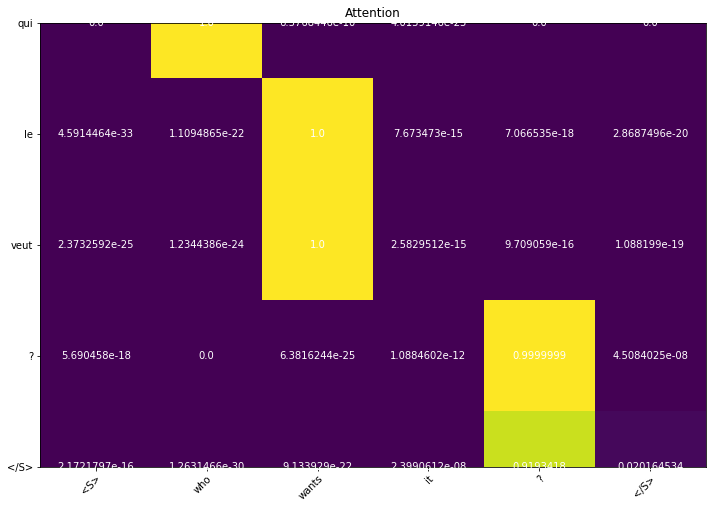

41



Loss: 1.830714225769043, Accuracy: 64.07768249511719, Test Loss: 2.609567642211914, Test Accuracy: 57.95569610595703
42



Loss: 1.8001294136047363, Accuracy: 64.56908416748047, Test Loss: 2.597195863723755, Test Accuracy: 58.18024826049805
43



Loss: 1.7703288793563843, Accuracy: 65.04841613769531, Test Loss: 2.584912061691284, Test Accuracy: 58.401153564453125
44



Loss: 1.741292119026184, Accuracy: 65.52040100097656, Test Loss: 2.5731279850006104, Test Accuracy: 58.61554718017578
45



Loss: 1.7131567001342773, Accuracy: 65.97931671142578, Test Loss: 2.5618200302124023, Test Accuracy: 58.824432373046875
46



Loss: 1.6858506202697754, Accuracy: 66.42745971679688, Test Loss: 2.5509984493255615, Test Accuracy: 59.02478790283203
47



Loss: 1.6594038009643555, Accuracy: 66.8631820678711, Test Loss: 2.54054856300354, Test Accuracy: 59.2193717956543
48



Loss: 1.633847713470459, Accuracy: 67.28362274169922, Test Loss: 2.5307650566101074, Test Accuracy: 59.408355712890625
49



Loss: 1.6089930534362793, Accuracy: 67.69329071044922, Test Loss: 2.521578311920166, Test Accuracy: 59.588043212890625
50



Loss: 1.5849229097366333, Accuracy: 68.0899658203125, Test Loss: 2.513073682785034, Test Accuracy: 59.76054763793945
<S> stay thin . </S>
reste doucement ! </S> ! </S> chose ! </S> . </S>
<S> who wants it ? </S>
qui veut ça ? </S> ? </S> ? </S> ? </S>


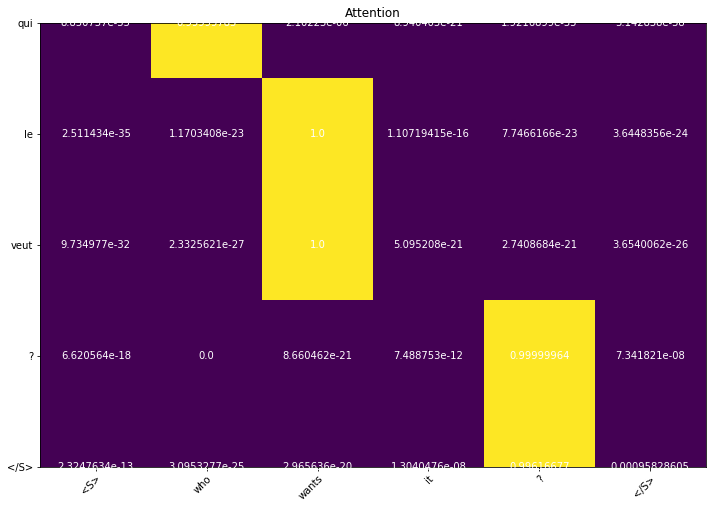

51



Loss: 1.561653733253479, Accuracy: 68.47527313232422, Test Loss: 2.5051586627960205, Test Accuracy: 59.923583984375
52



Loss: 1.5390642881393433, Accuracy: 68.8486557006836, Test Loss: 2.4975759983062744, Test Accuracy: 60.07869338989258
53



Loss: 1.5171961784362793, Accuracy: 69.20771026611328, Test Loss: 2.490206241607666, Test Accuracy: 60.227787017822266
54



Loss: 1.4959419965744019, Accuracy: 69.55618286132812, Test Loss: 2.4831104278564453, Test Accuracy: 60.37853240966797
55



Loss: 1.4752684831619263, Accuracy: 69.89554595947266, Test Loss: 2.4763119220733643, Test Accuracy: 60.52269744873047
56



Loss: 1.4552319049835205, Accuracy: 70.22386932373047, Test Loss: 2.469888925552368, Test Accuracy: 60.66141128540039
57



Loss: 1.4359192848205566, Accuracy: 70.53945922851562, Test Loss: 2.4636690616607666, Test Accuracy: 60.79419708251953
58



Loss: 1.4171438217163086, Accuracy: 70.84439086914062, Test Loss: 2.457827568054199, Test Accuracy: 60.92478561401367
59



Loss: 1.3987722396850586, Accuracy: 71.14643859863281, Test Loss: 2.4520363807678223, Test Accuracy: 61.04875183105469
60



Loss: 1.380835771560669, Accuracy: 71.44208526611328, Test Loss: 2.446599245071411, Test Accuracy: 61.16529083251953
<S> stay thin . </S>
reste doucement ! </S> ! </S> </S> chose ! </S> chose
<S> who wants it ? </S>
qui veut ça ? </S> ? </S> ? </S> ? </S>


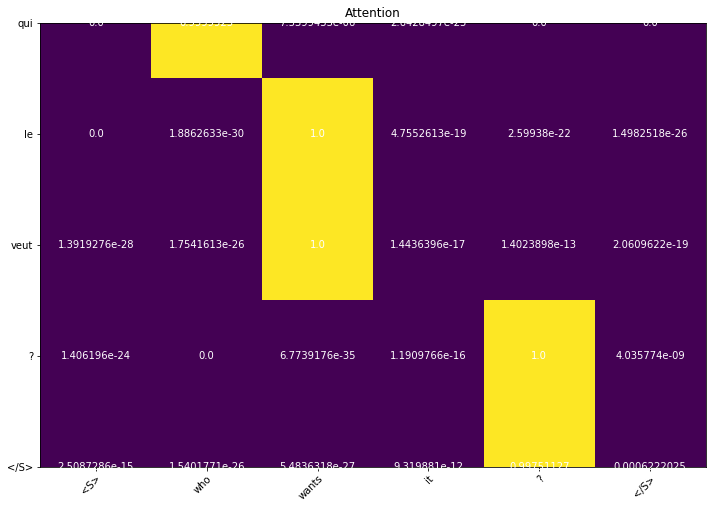

61



Loss: 1.3633660078048706, Accuracy: 71.72725677490234, Test Loss: 2.4412014484405518, Test Accuracy: 61.280967712402344
62



Loss: 1.3462682962417603, Accuracy: 72.00830841064453, Test Loss: 2.436000108718872, Test Accuracy: 61.39555740356445
63



Loss: 1.3296058177947998, Accuracy: 72.28190612792969, Test Loss: 2.4310667514801025, Test Accuracy: 61.512237548828125
64



Loss: 1.3133450746536255, Accuracy: 72.55049133300781, Test Loss: 2.4266326427459717, Test Accuracy: 61.61935806274414
65



Loss: 1.2974247932434082, Accuracy: 72.81269836425781, Test Loss: 2.422440767288208, Test Accuracy: 61.721336364746094
66



Loss: 1.2819139957427979, Accuracy: 73.0687255859375, Test Loss: 2.4183509349823, Test Accuracy: 61.82229995727539
67



Loss: 1.2668622732162476, Accuracy: 73.31704711914062, Test Loss: 2.414257287979126, Test Accuracy: 61.9260368347168
68



Loss: 1.252091407775879, Accuracy: 73.5638656616211, Test Loss: 2.4103331565856934, Test Accuracy: 62.02457046508789
69


In [ ]:

for epoch in range(1, epochs + 1):
    print(epoch,flush=True,)

    for x,y in tqdm(train_data):
        
        x,x_mask = tf.split(x,2,axis=1)
        x_out,y,y_mask = tf.split(y,3,axis=1)
        
        y_onehot = tf.one_hot(y,depth = word_vectors_fr.shape[0])
        loss,label,prediction = compute_apply_gradients(model,loss_f,x,x_mask,x_out,y_onehot,y_mask,optimizer)

        train_loss(loss)
        train_accuracy(label, prediction)
        
    for x,y in tqdm(test_data):

        x,x_mask = tf.split(x,2,axis=1)
        x_out,y,y_mask = tf.split(y,3,axis=1)
        
        y_out_onehot = tf.one_hot(y,depth = word_vectors_fr.shape[0])
        loss,label,prediction = compute_loss(model,loss_f,x,x_mask,x_out,y_out_onehot,y_mask)

        test_loss(loss)
        test_accuracy(label, prediction)
      
    print(
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}')
    
    tr_loss.append(train_loss.result())
    te_loss.append(test_loss.result())
    tr_acc.append(train_accuracy.result())
    te_acc.append(test_accuracy.result())
    if epoch % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    if epoch % 10 == 0:
        print(" ".join(ang[1000]))
        print(" ".join(model.generate(word_map_fr["<S>"],ang_tok[1000,:],ang_mask[1000,:])))

        print(" ".join(ang[5000]))
        print(" ".join(model.generate(word_map_fr["<S>"],ang_tok[5000,:],ang_mask[5000,:])))

        wei = model.att_wei(ang_tok[5000,:],ang_mask[5000,:],fra_tok[5000,:],fra_mask[5000,:])
        plot_weight(fra[5000],ang[5000],wei)



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(tr_loss, c="orange")
plt.plot(te_loss, c="blue")
plt.title("Loss")
plt.show()

plt.clf()
plt.plot(tr_acc, c="orange")
plt.plot(te_acc, c="red")
plt.title("Accuracy")
plt.show()

In [ ]:
wei = model.att_wei(ang_tok[5000,:],ang_mask[5000,:],fra_tok[5000,:],fra_mask[5000,:])
plot_weight(fra[5000],ang[5000],wei)